In [87]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE

from sklearn.model_selection import train_test_split
from ot.sliced import sliced_wasserstein_distance

In [88]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [89]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S80 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S80.rename(columns=lambda x: x + "_80" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S80, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


W_1_40     W_2_40     W_3_40     W_4_40     W_5_40     W_6_40  \
YEAR                                                                     
0     21.389266  26.985066  23.813756  26.852214  25.096705  26.852109   
1     21.314074  22.516442  24.072042  29.159849  29.522392  26.567033   
2     20.875083  26.038845  24.516708  27.633776  26.951667  27.926496   
3     20.553688  20.992986  22.859027  28.654018  26.705206  24.458350   
4     21.523342  21.542900  23.034072  26.327315  30.362289  27.503657   

         W_7_40     W_8_40     W_9_40   W_10_40  ...   W_10_80   W_11_80  \
YEAR                                             ...                       
0     25.730293  23.416002  21.038240  5.739711  ...  1.027391  1.228816   
1     28.249854  24.606161  19.268685  1.891106  ...  0.143191  0.925005   
2     26.534607  25.968638  23.554623  4.745318  ...  0.942601  1.811827   
3     25.146936  21.531644  22.961974  8.479863  ...  3.640015  0.956474   
4     27.839165  29.764479  18.290963  3.405621  ...  1.191167  0.049557   

       W_12_80   W_13_80   W_14_80   W_15_80   W_16_80   W_17_80   W_18_80  \
YEAR                                                                         
0     1.324273  2.309497  2.917570  0.769869  0.907157  3.401885  1.037317   
1     2.751680  1.196560  0.784046  1.505209  0.240757  1.617603  1.818209   
2     2.923051  0.384716  2.876004  1.535451  1.509938  1.652338  0.279352   
3     2.241502  1.893830  0.189264  2.049275  3.795690  0.404447  1.468172   
4     0.330440  2.860207  0.399063  0.506497  1.700047  0.216837  2.166599   

      YIELD_80  
YEAR            
0        10.51  
1         6.61  
2         6.86  
3         5.32  
4         6.32  

[5 rows x 76 columns]

In [90]:
dataset['Q40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])
dataset['Q49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])
dataset['Q63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])
dataset['Q80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_80']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q80']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 6.4897) & (dataset['Q49'] <= 3.3241) & (dataset['Q63'] <= 7.1301) & (dataset['Q80'] <= 5.1292)]
dataset.drop(['Q40', 'Q49', 'Q63', 'Q80'], axis=1, inplace=True)
print(dataset.shape)
dataset.head()

(1000, 76)


W_1_40     W_2_40     W_3_40     W_4_40     W_5_40     W_6_40  \
YEAR                                                                     
1     21.314074  22.516442  24.072042  29.159849  29.522392  26.567033   
2     20.875083  26.038845  24.516708  27.633776  26.951667  27.926496   
10    23.464658  23.112057  27.032350  26.348370  26.635686  27.142812   
28    24.495898  23.278987  23.563798  27.221256  25.471418  28.230339   
33    22.954317  23.373752  24.817940  26.166261  28.014204  29.420747   

         W_7_40     W_8_40     W_9_40   W_10_40  ...   W_10_80   W_11_80  \
YEAR                                             ...                       
1     28.249854  24.606161  19.268685  1.891106  ...  0.143191  0.925005   
2     26.534607  25.968638  23.554623  4.745318  ...  0.942601  1.811827   
10    30.421238  24.051925  18.585785  0.692692  ...  0.587621  0.473142   
28    27.622846  23.942648  20.273115  2.315491  ...  0.169986  0.376775   
33    27.174332  26.733400  20.511923  0.827020  ...  1.526391  3.749390   

       W_12_80   W_13_80   W_14_80   W_15_80   W_16_80   W_17_80   W_18_80  \
YEAR                                                                         
1     2.751680  1.196560  0.784046  1.505209  0.240757  1.617603  1.818209   
2     2.923051  0.384716  2.876004  1.535451  1.509938  1.652338  0.279352   
10    0.816458  0.573914  0.174179  2.236641  0.175408  2.514701  2.153090   
28    1.874452  0.343077  1.527473  0.417273  0.691531  2.872908  1.997046   
33    0.511152  0.536142  0.158058  0.958499  2.007874  0.499257  4.017396   

      YIELD_80  
YEAR            
1         6.61  
2         6.86  
10        6.04  
28        6.08  
33        3.51  

[5 rows x 76 columns]

In [91]:
#Some feature engineering for later

dataset['AvgTemp_1_40'] = (dataset['W_1_40'] + dataset['W_2_40'] + dataset['W_3_40'])/3
dataset['AvgTemp_1_49'] = (dataset['W_1_49'] + dataset['W_2_49'] + dataset['W_3_49'])/3
dataset['AvgTemp_1_63'] = (dataset['W_1_63'] + dataset['W_2_63'] + dataset['W_3_63'])/3
dataset['AvgTemp_1_80'] = (dataset['W_1_80'] + dataset['W_2_80'] + dataset['W_3_80'])/3

dataset['AvgTemp_2_40'] = (dataset['W_4_40'] + dataset['W_5_40'] + dataset['W_6_40'])/3
dataset['AvgTemp_2_49'] = (dataset['W_4_49'] + dataset['W_5_49'] + dataset['W_6_49'])/3
dataset['AvgTemp_2_63'] = (dataset['W_4_63'] + dataset['W_5_63'] + dataset['W_6_63'])/3
dataset['AvgTemp_2_80'] = (dataset['W_4_80'] + dataset['W_5_80'] + dataset['W_6_80'])/3

dataset['AvgTemp_3_40'] = (dataset['W_7_40'] + dataset['W_8_40'] + dataset['W_9_40'])/3
dataset['AvgTemp_3_49'] = (dataset['W_7_49'] + dataset['W_8_49'] + dataset['W_9_49'])/3
dataset['AvgTemp_3_63'] = (dataset['W_7_63'] + dataset['W_8_63'] + dataset['W_9_63'])/3
dataset['AvgTemp_3_80'] = (dataset['W_7_80'] + dataset['W_8_80'] + dataset['W_9_80'])/3

dataset['AvgWeath_1_40'] = (dataset['W_10_40'] + dataset['W_11_40'] + dataset['W_12_40'])/3
dataset['AvgWeath_1_49'] = (dataset['W_10_49'] + dataset['W_11_49'] + dataset['W_12_49'])/3
dataset['AvgWeath_1_63'] = (dataset['W_10_63'] + dataset['W_11_63'] + dataset['W_12_63'])/3
dataset['AvgWeath_1_80'] = (dataset['W_10_80'] + dataset['W_11_80'] + dataset['W_12_80'])/3

dataset['AvgWeath_2_40'] = (dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40'])/3
dataset['AvgWeath_2_49'] = (dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49'])/3
dataset['AvgWeath_2_63'] = (dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63'])/3
dataset['AvgWeath_2_80'] = (dataset['W_13_80'] + dataset['W_14_80'] + dataset['W_15_80'])/3

dataset['AvgWeath_3_40'] = (dataset['W_16_40'] + dataset['W_17_40'] + dataset['W_18_40'])/3
dataset['AvgWeath_3_49'] = (dataset['W_16_49'] + dataset['W_17_49'] + dataset['W_18_49'])/3
dataset['AvgWeath_3_63'] = (dataset['W_16_63'] + dataset['W_17_63'] + dataset['W_18_63'])/3
dataset['AvgWeath_3_80'] = (dataset['W_16_80'] + dataset['W_17_80'] + dataset['W_18_80'])/3


In [92]:
#Train / Test split :
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=seed)

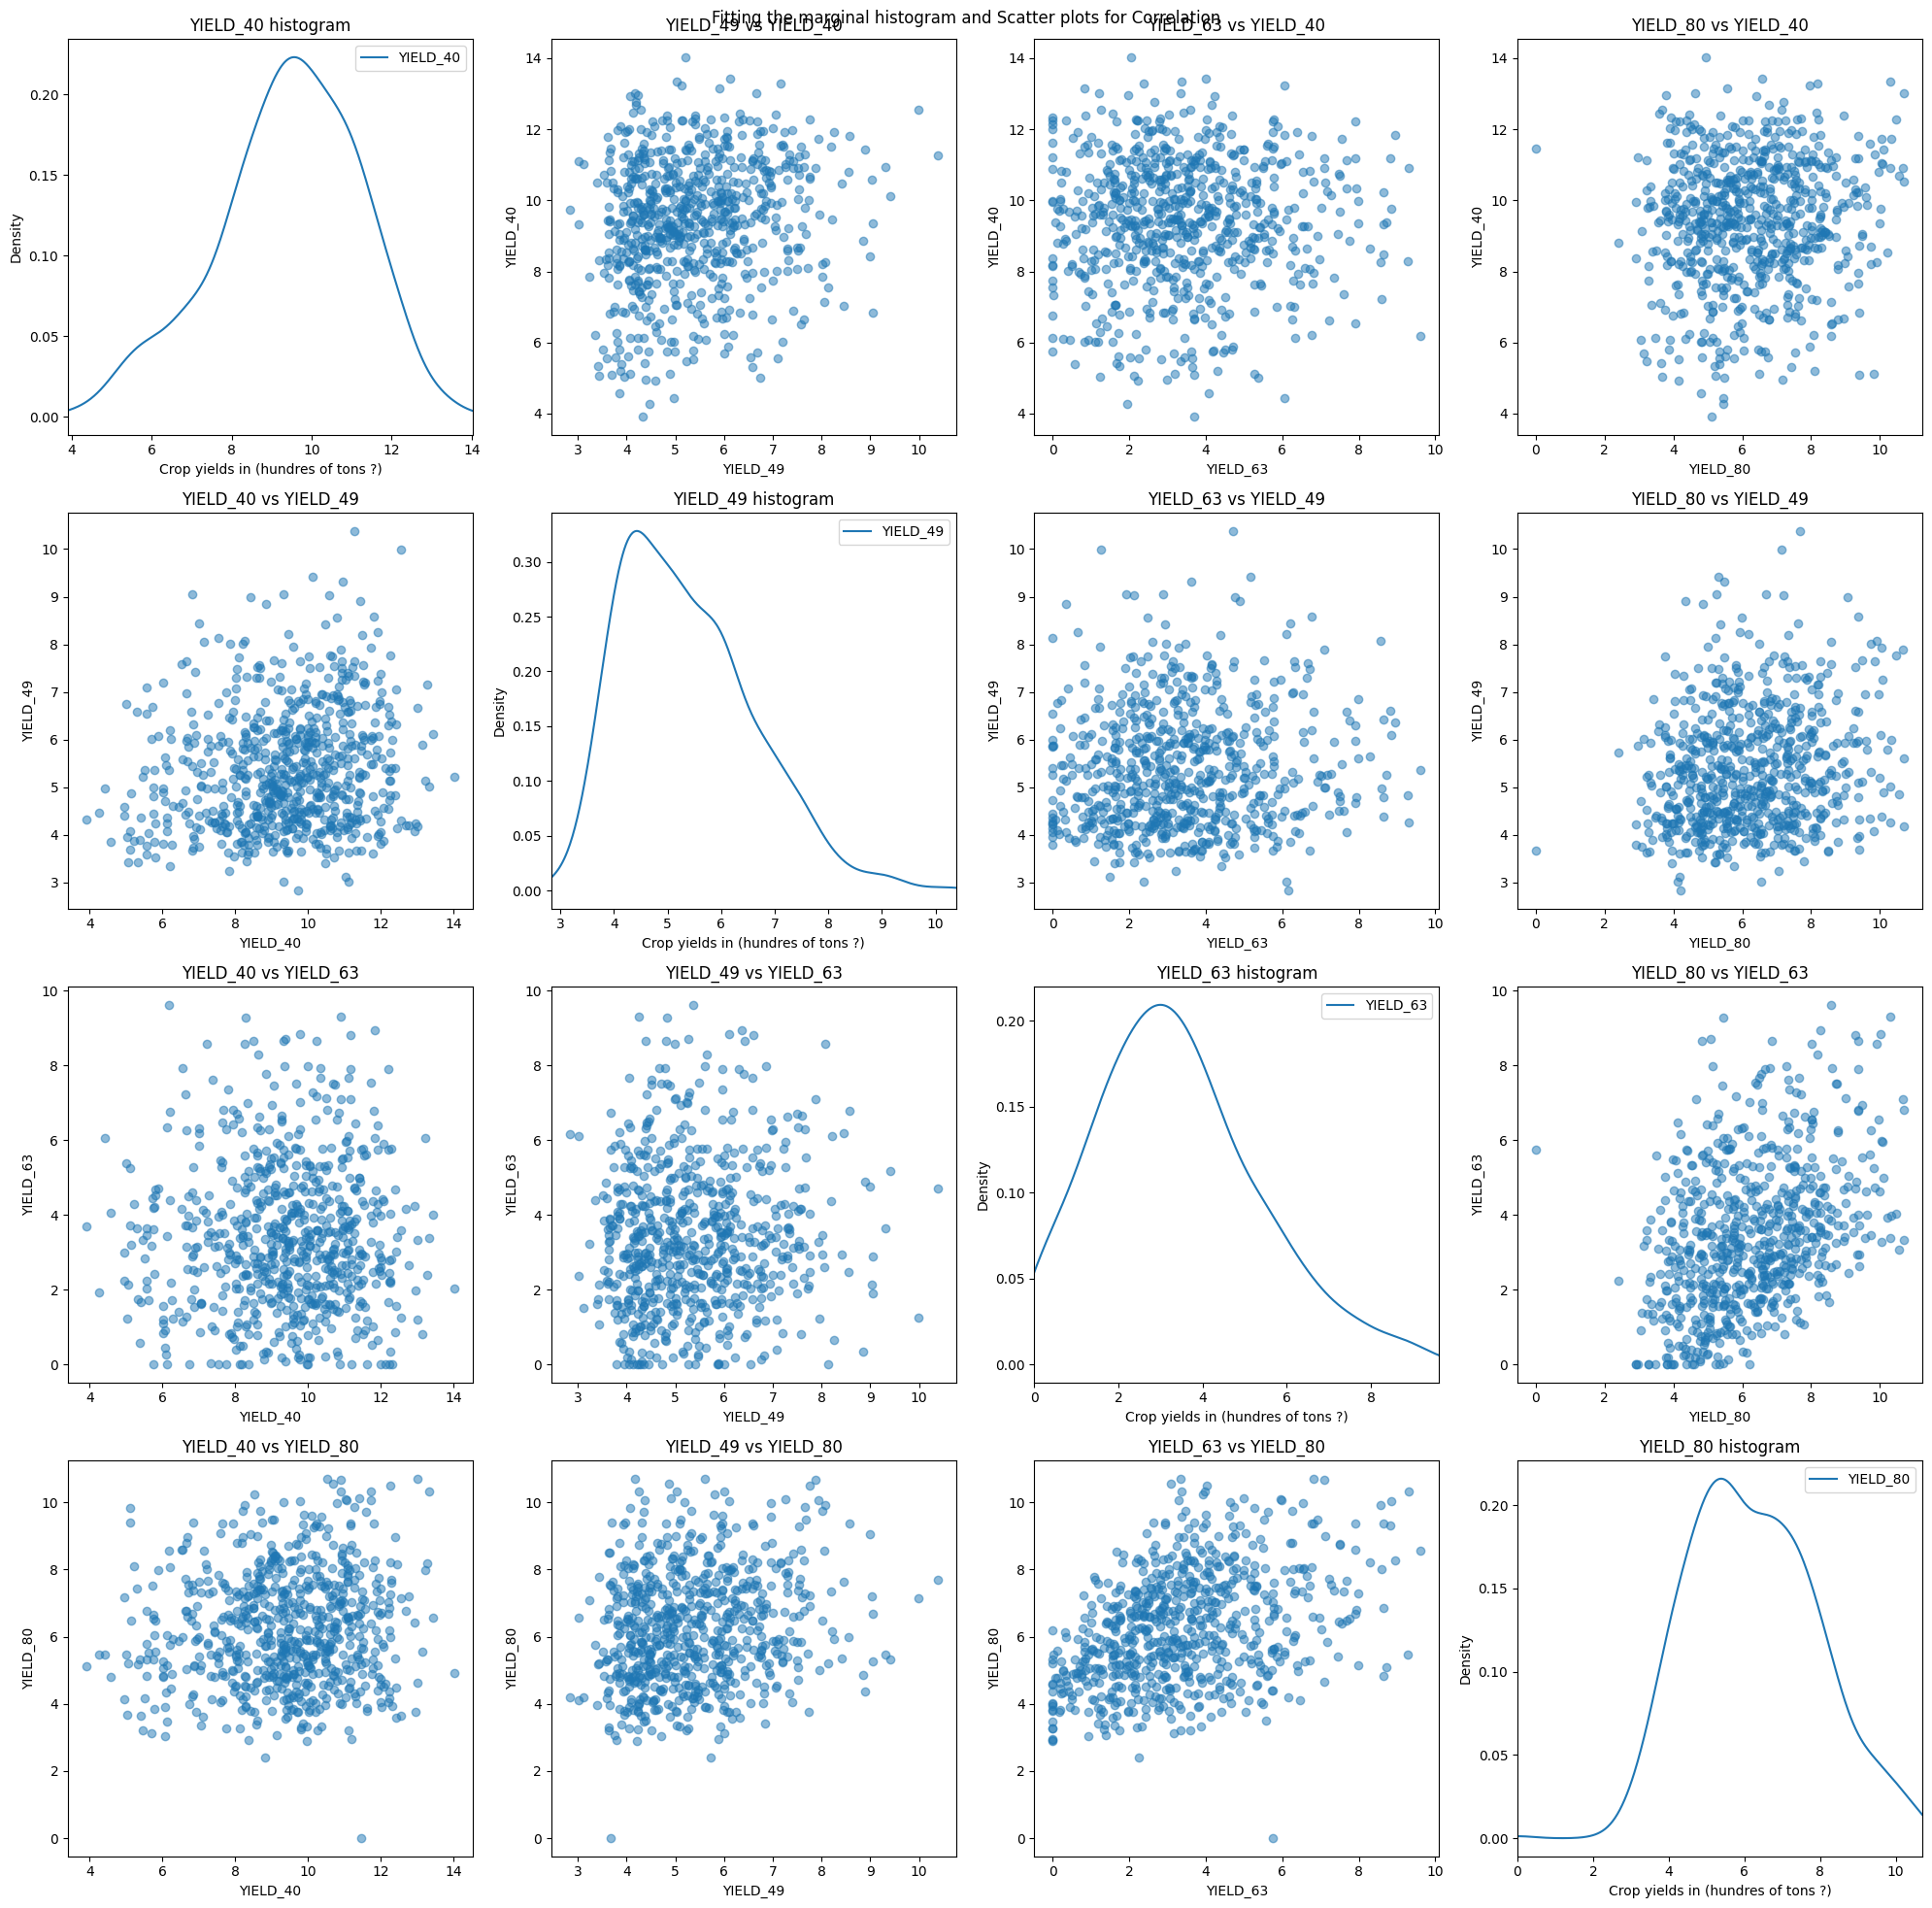

In [93]:
# Use only the YIELD data :
X= train_data[features]
X_train = X.copy()
X_test = test_data[features]

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(len(X.columns)):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    mu, std = X[yield_ind].mean(), X[yield_ind].std()
    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]

            plt.scatter(x, y, alpha=0.5)
            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

GAN on yields + weather:

In [94]:
from GAN import Generator, Discriminator
from utils import ED_model_step
from utils import D_train, G_train
from utils import D_wasserstrain, G_wasserstrain
from utils import make_fake_data, make_fake_data_renorm

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

device cuda


In [96]:
batch_size = 32
g_hidden_dim = 16
d_hidden_dim = 16
lr = 0.002
latent_dim = 16
epochs = 100

In [97]:
# idx_list = ['1','2','3']
idx_list = ['2']
weather = ['AvgTemp_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list] + ['AvgWeath_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list]
X_all = train_data[features + weather]

In [98]:
X_all

YIELD_40  YIELD_49  YIELD_63  YIELD_80  AvgTemp_2_40  AvgTemp_2_49  \
YEAR                                                                       
2902     12.40      4.83      4.69      8.96     25.951549     26.161030   
8722     10.94      5.67      2.66      8.41     27.725017     28.137655   
2698     11.14      6.12      5.00      7.99     27.531708     28.074013   
6664      9.85      3.93      2.93      9.33     26.465626     26.485885   
1850     11.99      3.82      3.99      7.43     28.084637     28.069326   
...        ...       ...       ...       ...           ...           ...   
8736      7.99      6.83      2.71      4.50     28.085615     28.618729   
429       7.92      6.43      0.74      4.99     25.054002     24.847149   
7754     10.48      4.58      2.12      4.95     25.694169     26.354214   
9036      9.37      6.11      3.56      6.74     26.666430     27.448052   
2501      5.07      3.43      2.13      5.22     25.148667     25.240447   

      AvgTemp_2_63  AvgTemp_2_80  AvgWeath_2_40  AvgWeath_2_49  AvgWeath_2_63  \
YEAR                                                                            
2902     22.895729     24.195787       1.930771       0.691968       1.629589   
8722     23.904982     25.393916       1.595069       0.585510       1.555819   
2698     23.744517     25.861871       2.072697       0.808080       1.724033   
6664     22.281003     24.311570       1.831836       0.652538       1.597134   
1850     24.301437     26.298008       1.918609       0.823326       1.977645   
...            ...           ...            ...            ...            ...   
8736     23.554547     25.542799       1.373483       0.878338       1.880244   
429      19.623459     22.215870       1.478408       1.089627       2.258621   
7754     20.620372     23.422136       1.388254       0.562400       1.290711   
9036     22.943256     24.949193       1.321733       0.693993       1.346800   
2501     19.559868     21.965627       1.475496       0.432112       2.235179   

      AvgWeath_2_80  
YEAR                 
2902       1.469756  
8722       1.559404  
2698       1.001780  
6664       1.583769  
1850       1.378898  
...             ...  
8736       0.745135  
429        1.146013  
7754       1.094313  
9036       1.404383  
2501       1.092134  

[700 rows x 12 columns]

In [99]:
import torch.utils.data as data_utils

train = torch.tensor(X_all.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

Standardizing the data may help

In [100]:
# standardize data
# means = train.mean(dim=0, keepdim=True)
# stds = train.std(dim=0, keepdim=True)
# train_normalized = (train - means) / stds
# test_normalized = (test - means) / stds

# train_dataset = data_utils.TensorDataset(train_normalized) 
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = args.batch_size, shuffle = True)


In [101]:
from tqdm import tqdm

dim = X_all.shape[1]
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_train(latent_dim, x, G, D, D_optimizer, device)
            g_loss = G_train(latent_dim, x, G, D, G_optimizer, device)
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        if (k + 1) %10 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

100: discriminator loss -1.387 generator loss 0.694 time 7.00


200: discriminator loss -1.387 generator loss 0.696 time 13.88


300: discriminator loss -1.387 generator loss 0.692 time 20.70


400: discriminator loss -1.386 generator loss 0.693 time 27.53


500: discriminator loss -1.386 generator loss 0.694 time 34.58


600: discriminator loss -1.386 generator loss 0.693 time 40.99


700: discriminator loss -1.386 generator loss 0.693 time 47.65


800: discriminator loss -1.386 generator loss 0.694 time 54.53


900: discriminator loss -1.386 generator loss 0.693 time 61.54


1000: discriminator loss -1.386 generator loss 0.694 time 68.48


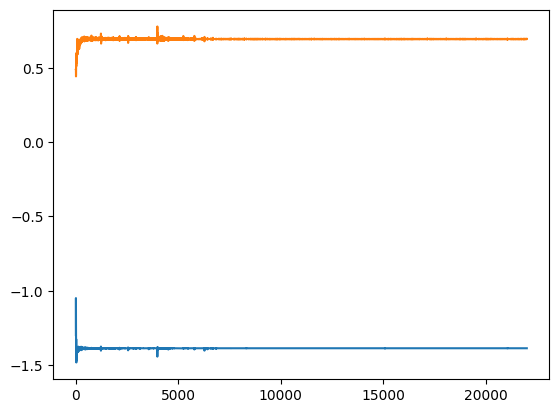

In [102]:
plt.plot(d_losses)
plt.plot(g_losses)

In [103]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)[:,:4]

In [104]:
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.9079360205936605
test SWD = 1.0051331265998928


In [105]:
samples = pd.DataFrame(samples)

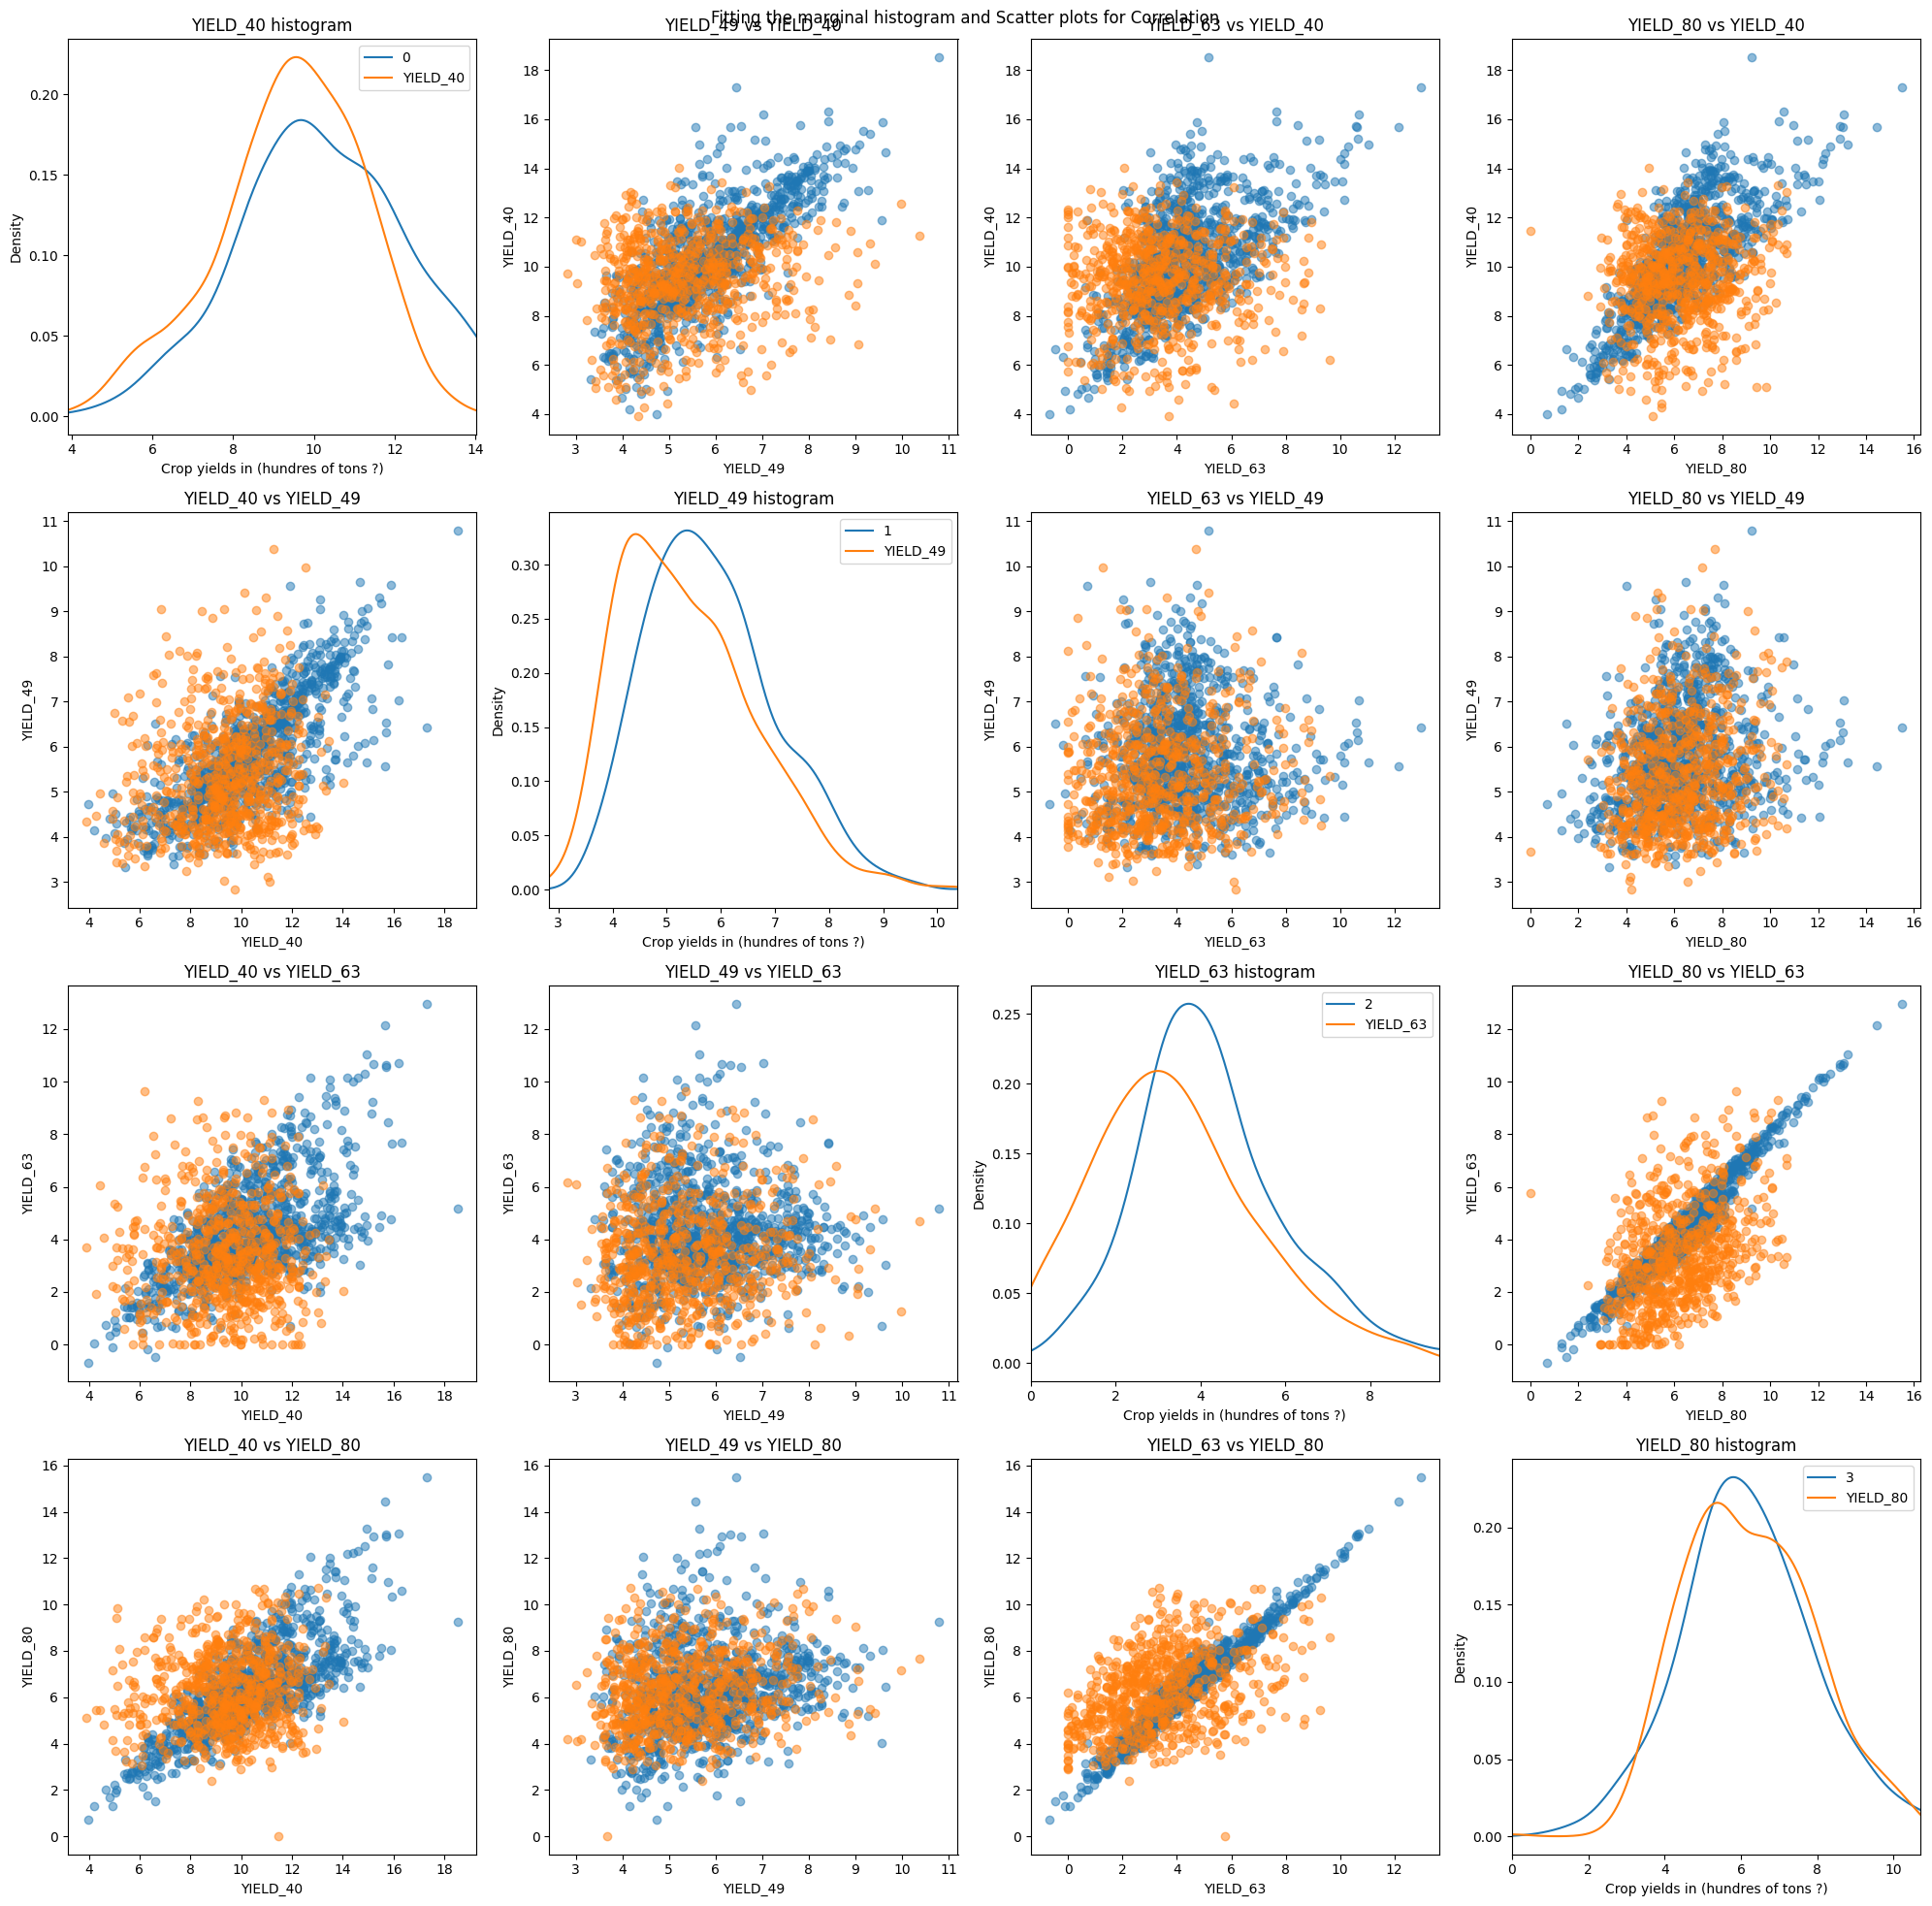

In [106]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Wasserstein GAN

Data normalization - important due to clipping performed

In [107]:
# idx_list = ['1','2','3']
idx_list = ['2']
weather = ['AvgTemp_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list] + ['AvgWeath_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list]
X_all = train_data[features + weather]

In [108]:
train = torch.tensor(X_all.values.astype(np.float32))

In [109]:
# transform data before
means = train.mean(dim=0, keepdim=True)
stds = train.std(dim=0, keepdim=True)
train_normalized = (train - means) / stds

In [110]:
train_dataset_normalized = data_utils.TensorDataset(train_normalized)
train_loader_normalized = data_utils.DataLoader(dataset = train_dataset_normalized, batch_size = batch_size, shuffle = True)

In [125]:
# batch_size = 32
# g_hidden_dim = 32
# d_hidden_dim = 64
# lr = 0.001
# latent_dim = 16
# epochs = 100

In [167]:
batch_size = 32
g_hidden_dim = 128
d_hidden_dim = 128
lr = 0.005
latent_dim = 50
epochs = 100

In [168]:
dim = X_all.shape[1]
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader_normalized), total=len(train_loader_normalized), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_wasserstrain(latent_dim, x, G, D, D_optimizer, device)
            if batch_idx % 5 == 0:
                g_loss = G_wasserstrain(latent_dim, x, G, D, G_optimizer, device)
                d_losses.append(d_loss)
                g_losses.append(g_loss)

        if (k + 1) %10 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

10: discriminator loss 0.000 generator loss -0.502 time 0.48


20: discriminator loss 0.000 generator loss -0.502 time 0.94


30: discriminator loss 0.000 generator loss -0.500 time 1.46


40: discriminator loss 0.000 generator loss -0.500 time 1.92


50: discriminator loss 0.000 generator loss -0.500 time 2.35


60: discriminator loss 0.000 generator loss -0.500 time 2.78


70: discriminator loss 0.000 generator loss -0.500 time 3.18


80: discriminator loss 0.000 generator loss -0.500 time 3.69


90: discriminator loss 0.000 generator loss -0.500 time 4.13


100: discriminator loss 0.000 generator loss -0.500 time 4.54


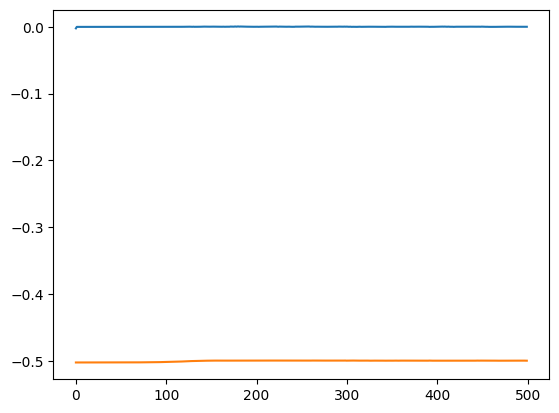

In [169]:
plt.plot(d_losses)
plt.plot(g_losses)

In [170]:
nb_samples = 1000
samples = make_fake_data_renorm("normal", n=nb_samples, latent_dim=latent_dim, G=G, means=means, stds=stds)[:,:4]
samples = pd.DataFrame(samples)

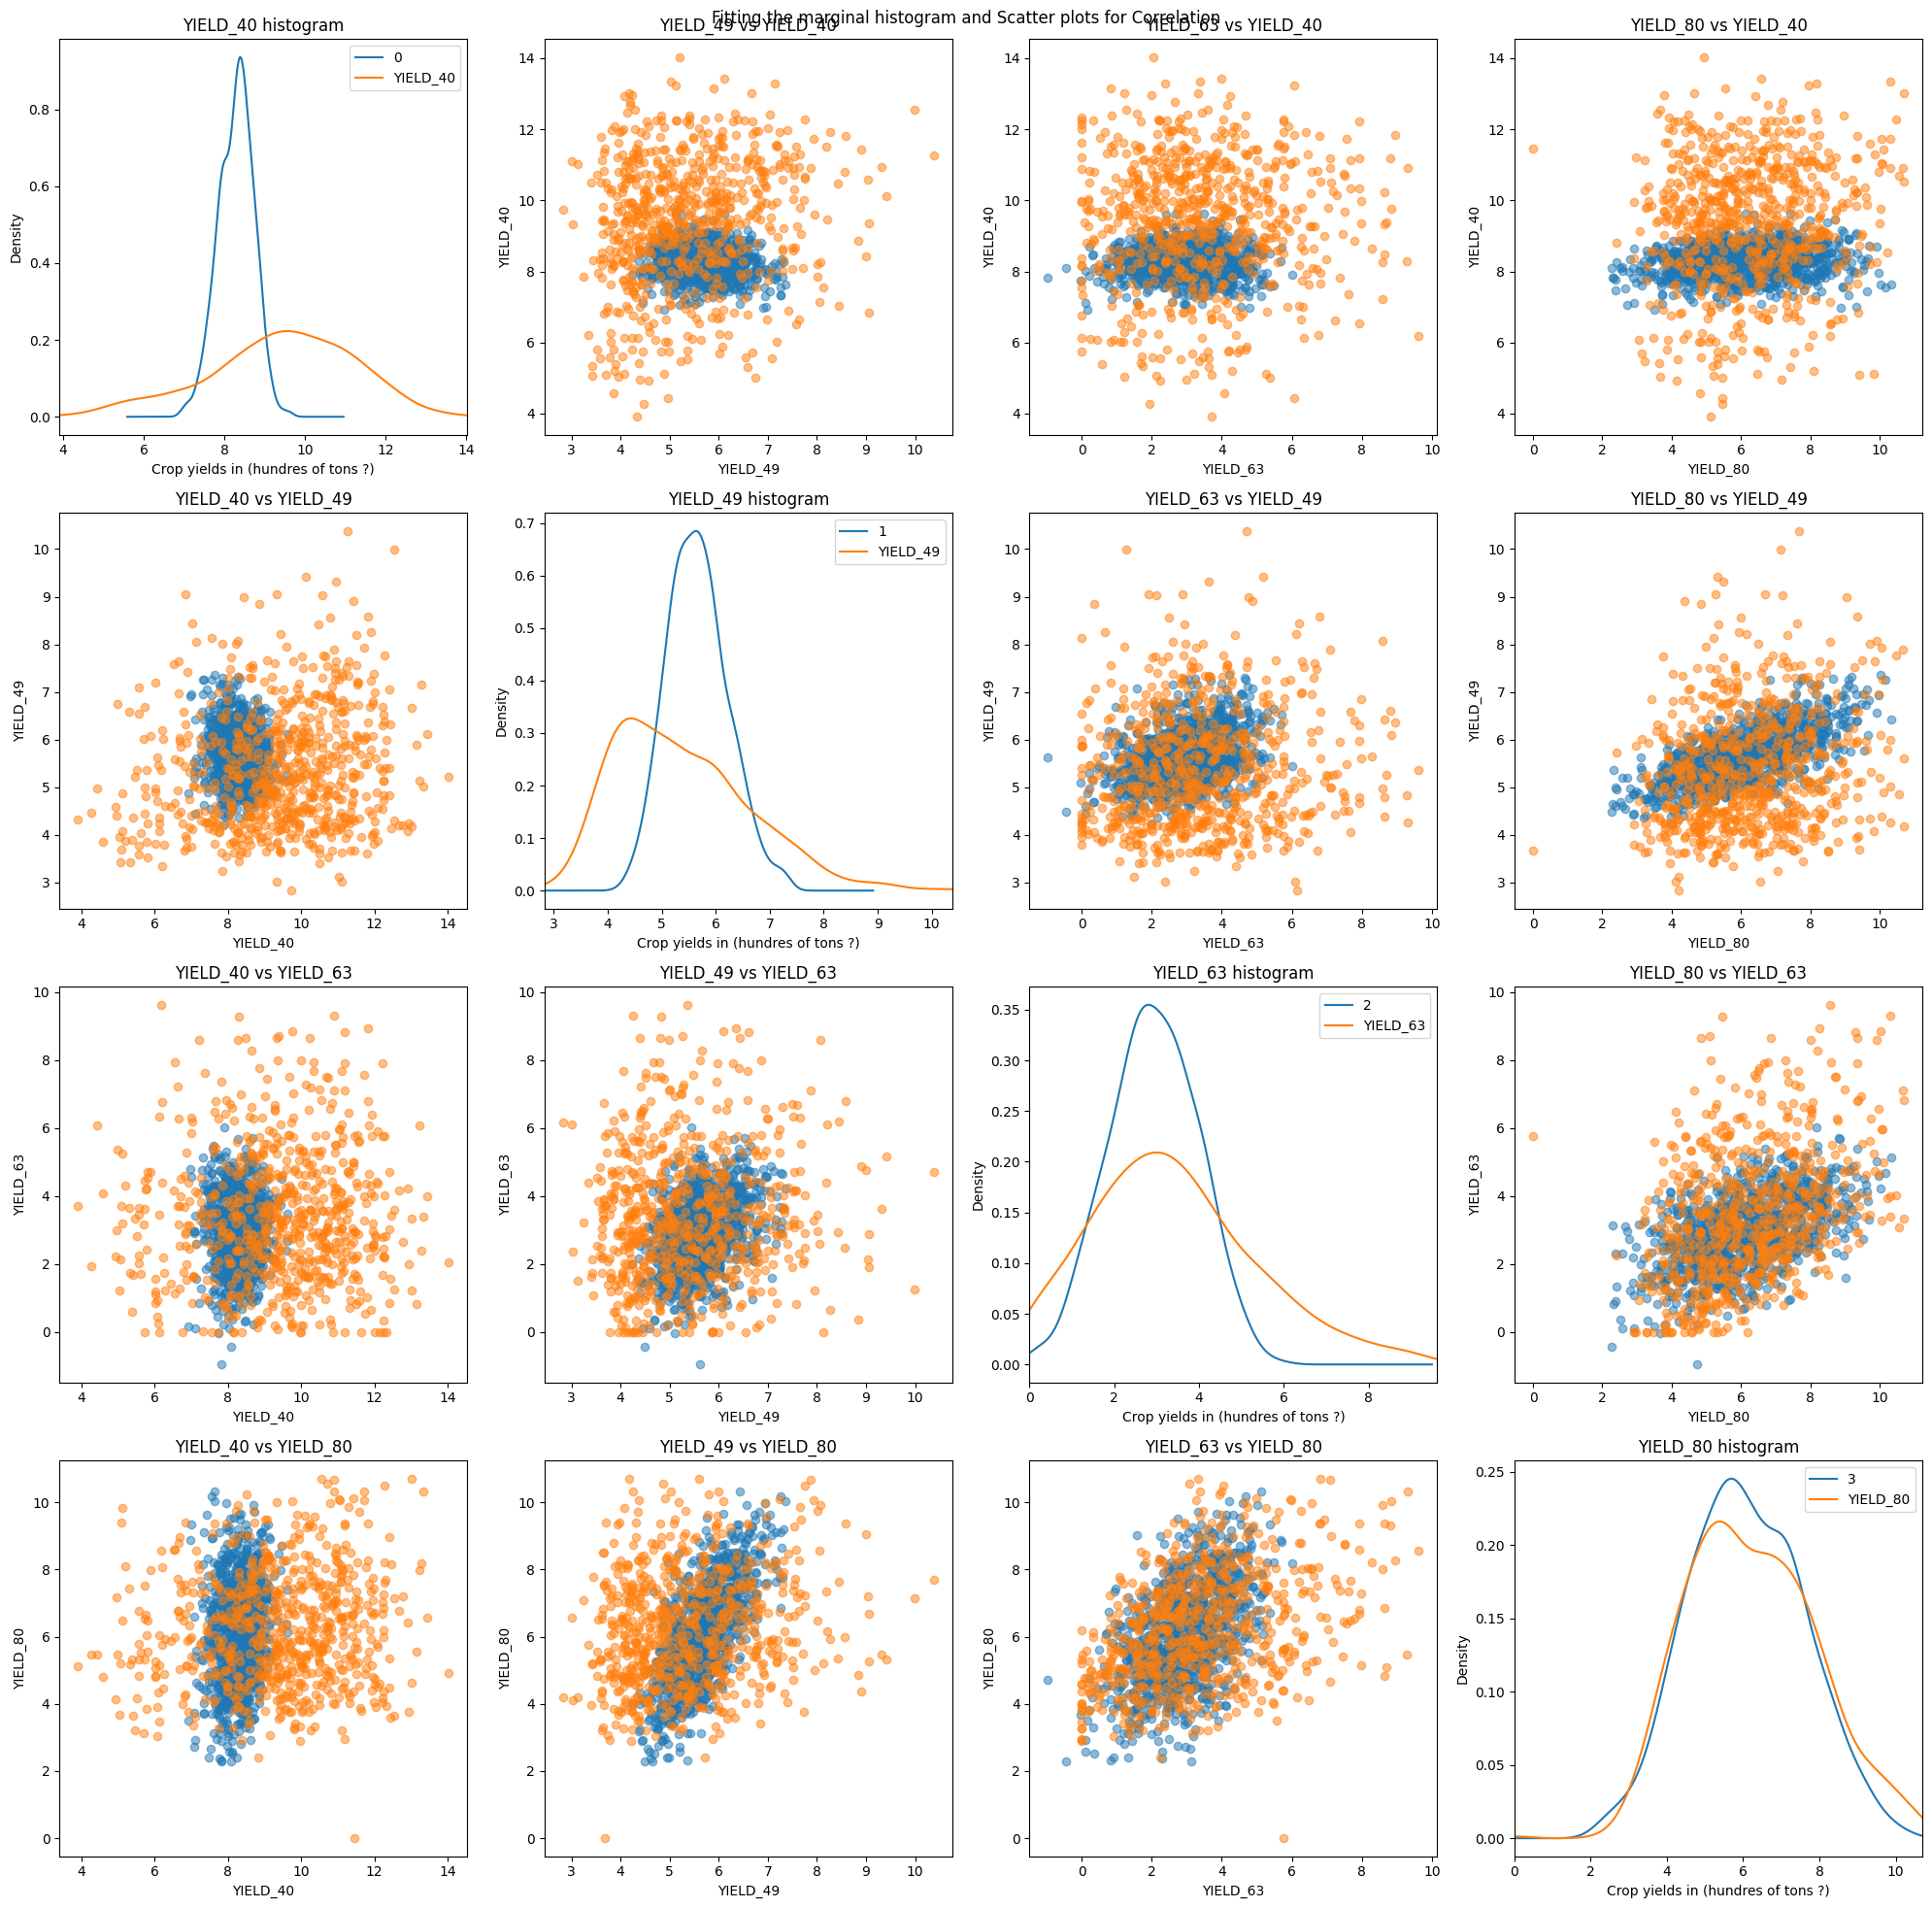

In [171]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [172]:
nb_samples = 1000
samples = make_fake_data_renorm("normal", n=nb_samples, latent_dim=latent_dim, G=G, means=means, stds=stds)[:,:4]
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 1.0141272001635862
test SWD = 0.9565497492483871


# Energy distance minimization

In [117]:
# idx_list = ['1','2','3']
idx_list = ['2']
weather = ['AvgTemp_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list] + ['AvgWeath_'+i+'_'+s for s in ['40', '49', '63', '80'] for i in idx_list]
X_all = train_data[features + weather]

In [118]:
train = torch.tensor(X_all.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [119]:
batch_size = 32
g_hidden_dim = 32
d_hidden_dim = 64
lr = 0.001
latent_dim = 16
epochs = 1000

In [120]:
dim = X_all.shape[1]
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)

losses = []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            loss = ED_model_step(latent_dim, x, G, G_optimizer, device, "normal")
            losses.append(loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

100: discriminator loss 0.000 generator loss -0.500 time 2.87


200: discriminator loss 0.000 generator loss -0.500 time 5.61


300: discriminator loss 0.000 generator loss -0.500 time 8.15


400: discriminator loss 0.000 generator loss -0.500 time 10.85


500: discriminator loss 0.000 generator loss -0.500 time 13.73


600: discriminator loss 0.000 generator loss -0.500 time 16.46


700: discriminator loss 0.000 generator loss -0.500 time 19.17


800: discriminator loss 0.000 generator loss -0.500 time 21.85


900: discriminator loss 0.000 generator loss -0.500 time 24.53


1000: discriminator loss 0.000 generator loss -0.500 time 27.38


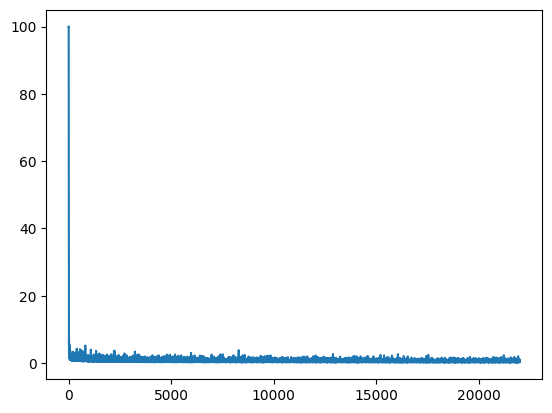

In [121]:
plt.plot(losses)

In [122]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)[:,:4]
samples = pd.DataFrame(samples)

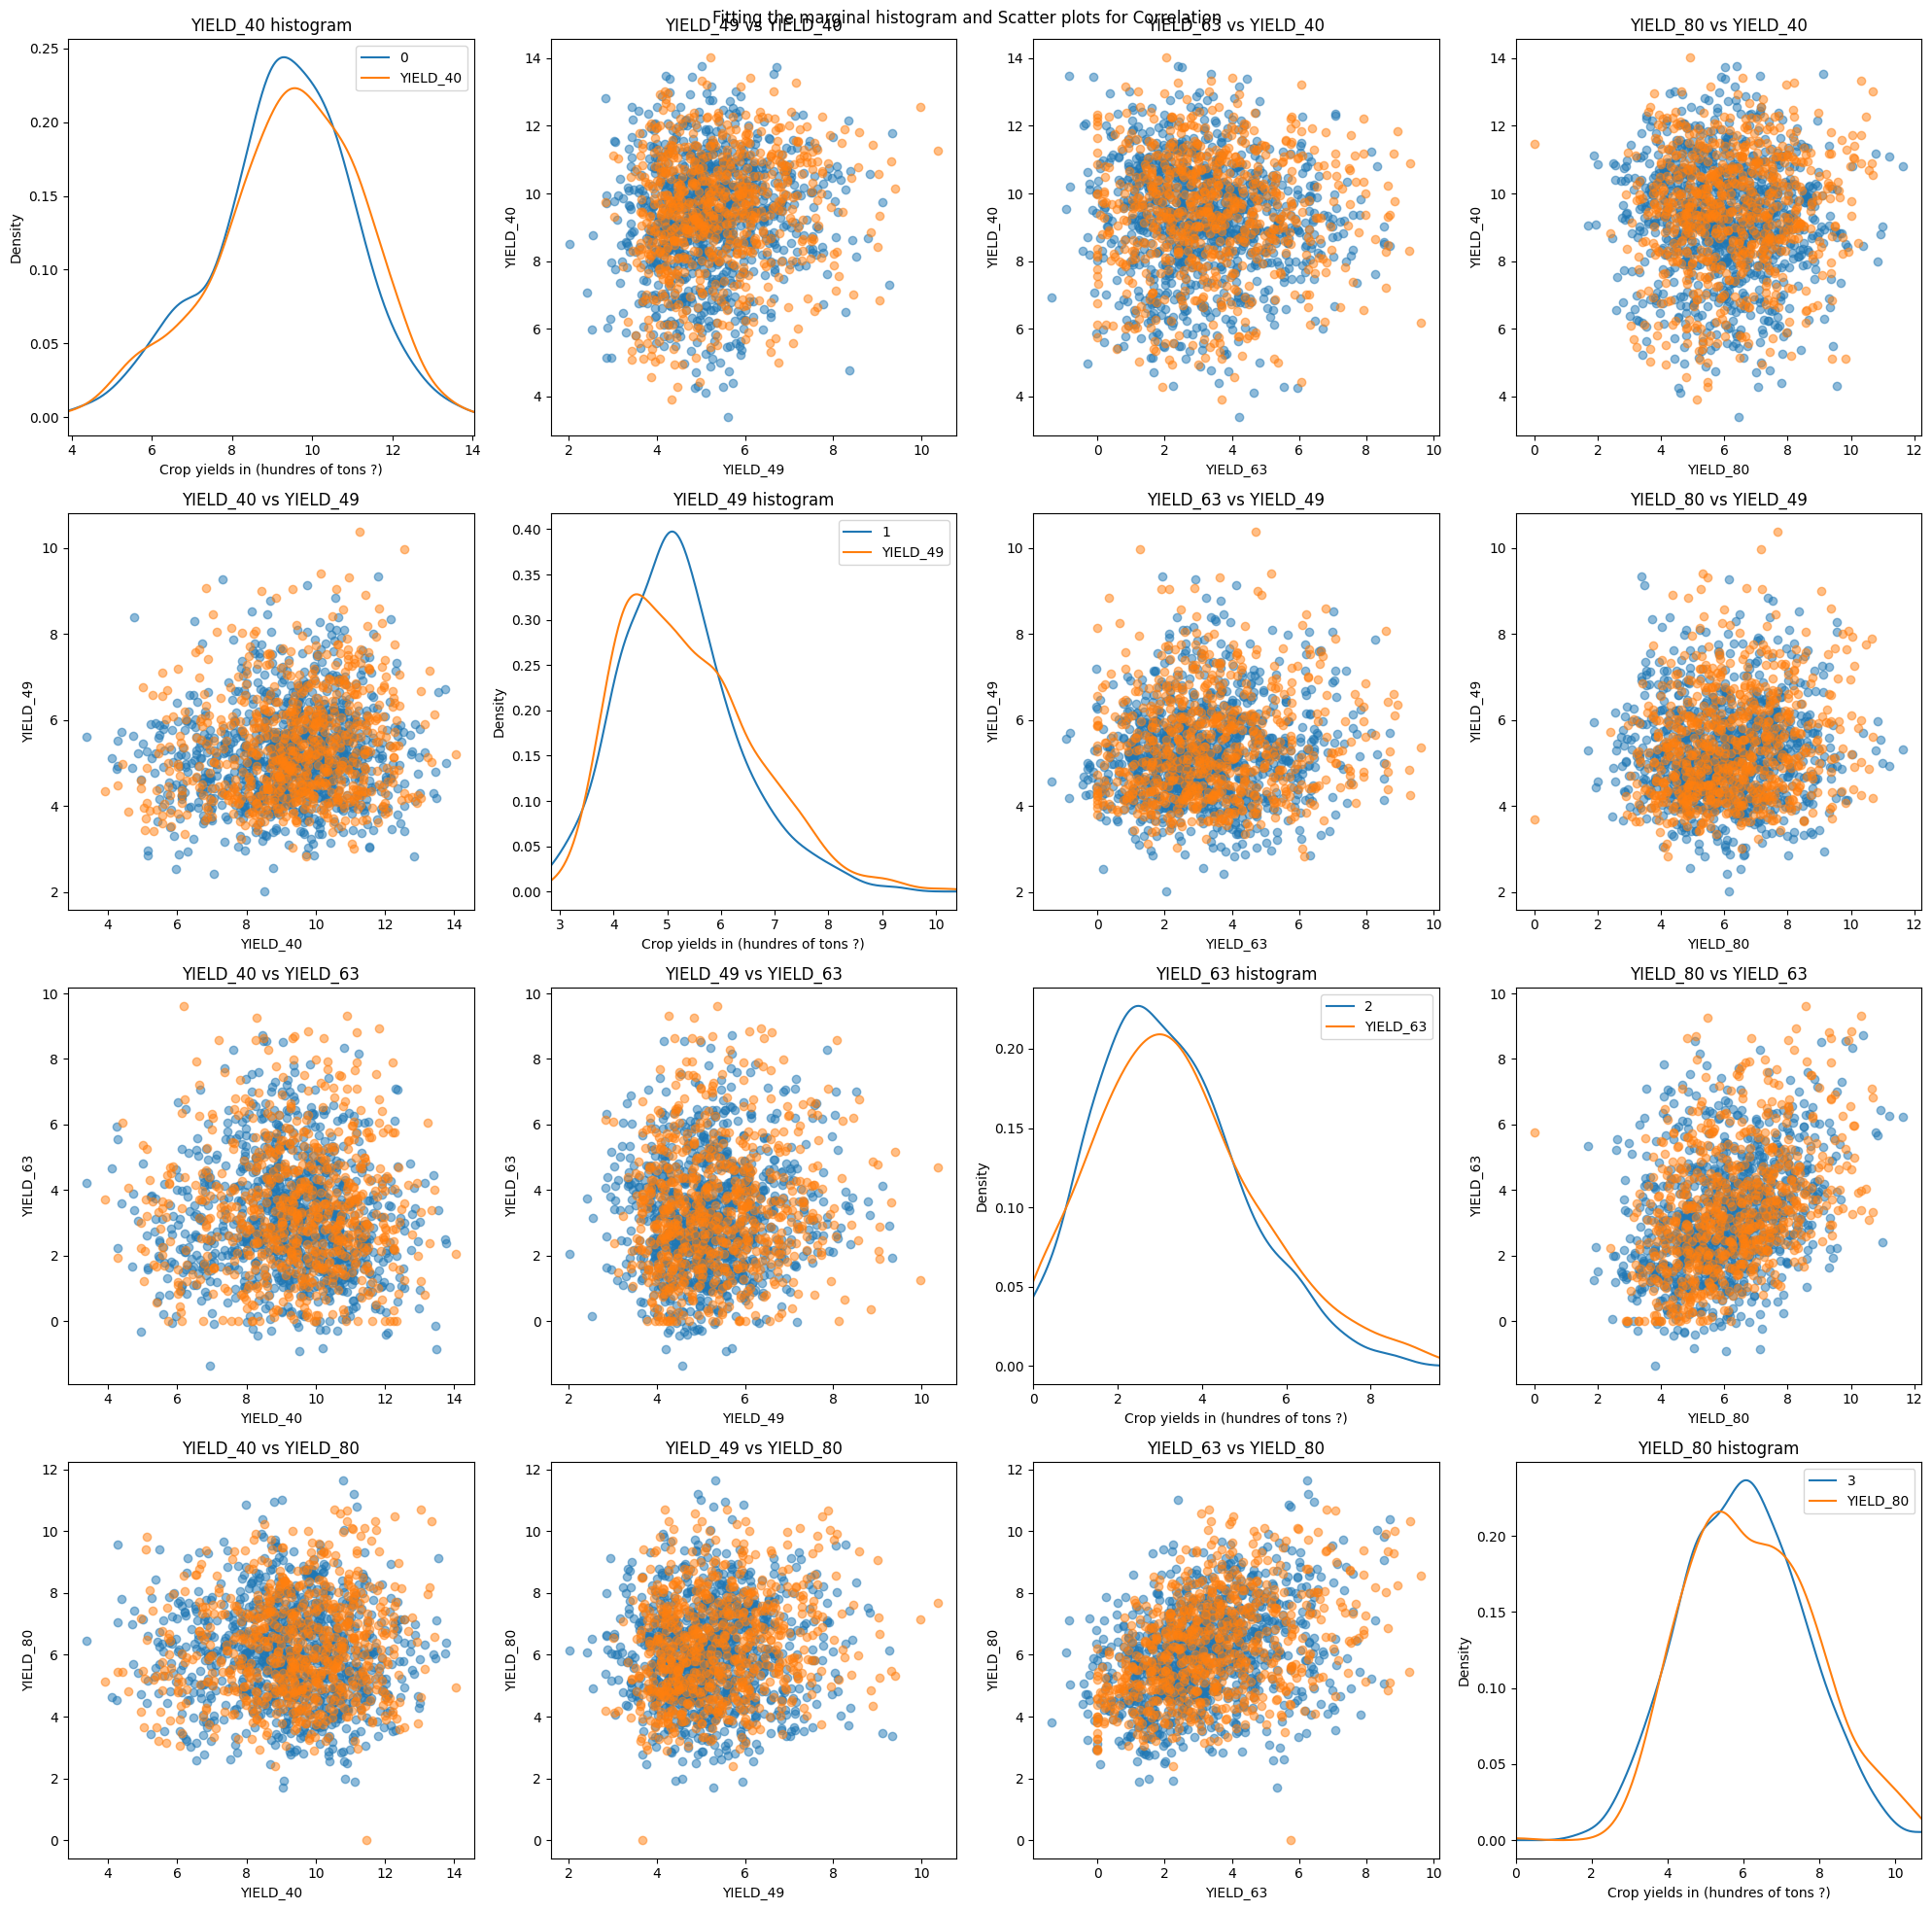

In [123]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [124]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)[:,:4]
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.2544511438708004
test SWD = 0.2395314182696433


# Energy distance - larger

In [52]:
X_train.shape

(700, 4)

In [51]:
X_test.shape

(300, 4)

In [ ]:
X.shape

In [69]:
batch_size = 32
g_hidden_dim = 16
d_hidden_dim = 16
lr = 0.001
latent_dim = 4
epochs = 1000

In [70]:
train = torch.tensor(X.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)

losses = []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            loss = ED_model_step(latent_dim, x, G, G_optimizer, device, "normal")
            losses.append(loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

100: discriminator loss 0.000 generator loss -0.502 time 2.76


200: discriminator loss 0.000 generator loss -0.502 time 5.40


300: discriminator loss 0.000 generator loss -0.502 time 7.99


400: discriminator loss 0.000 generator loss -0.502 time 10.58


500: discriminator loss 0.000 generator loss -0.502 time 12.93


600: discriminator loss 0.000 generator loss -0.502 time 15.35


700: discriminator loss 0.000 generator loss -0.502 time 17.88


800: discriminator loss 0.000 generator loss -0.502 time 20.24


900: discriminator loss 0.000 generator loss -0.502 time 22.71


1000: discriminator loss 0.000 generator loss -0.502 time 25.12


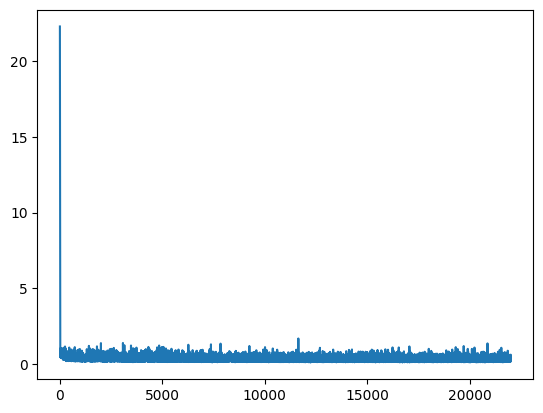

In [71]:
plt.plot(losses)

In [72]:
samples = make_fake_data("normal", n=289, latent_dim=latent_dim, G=G)
samples = pd.DataFrame(samples)

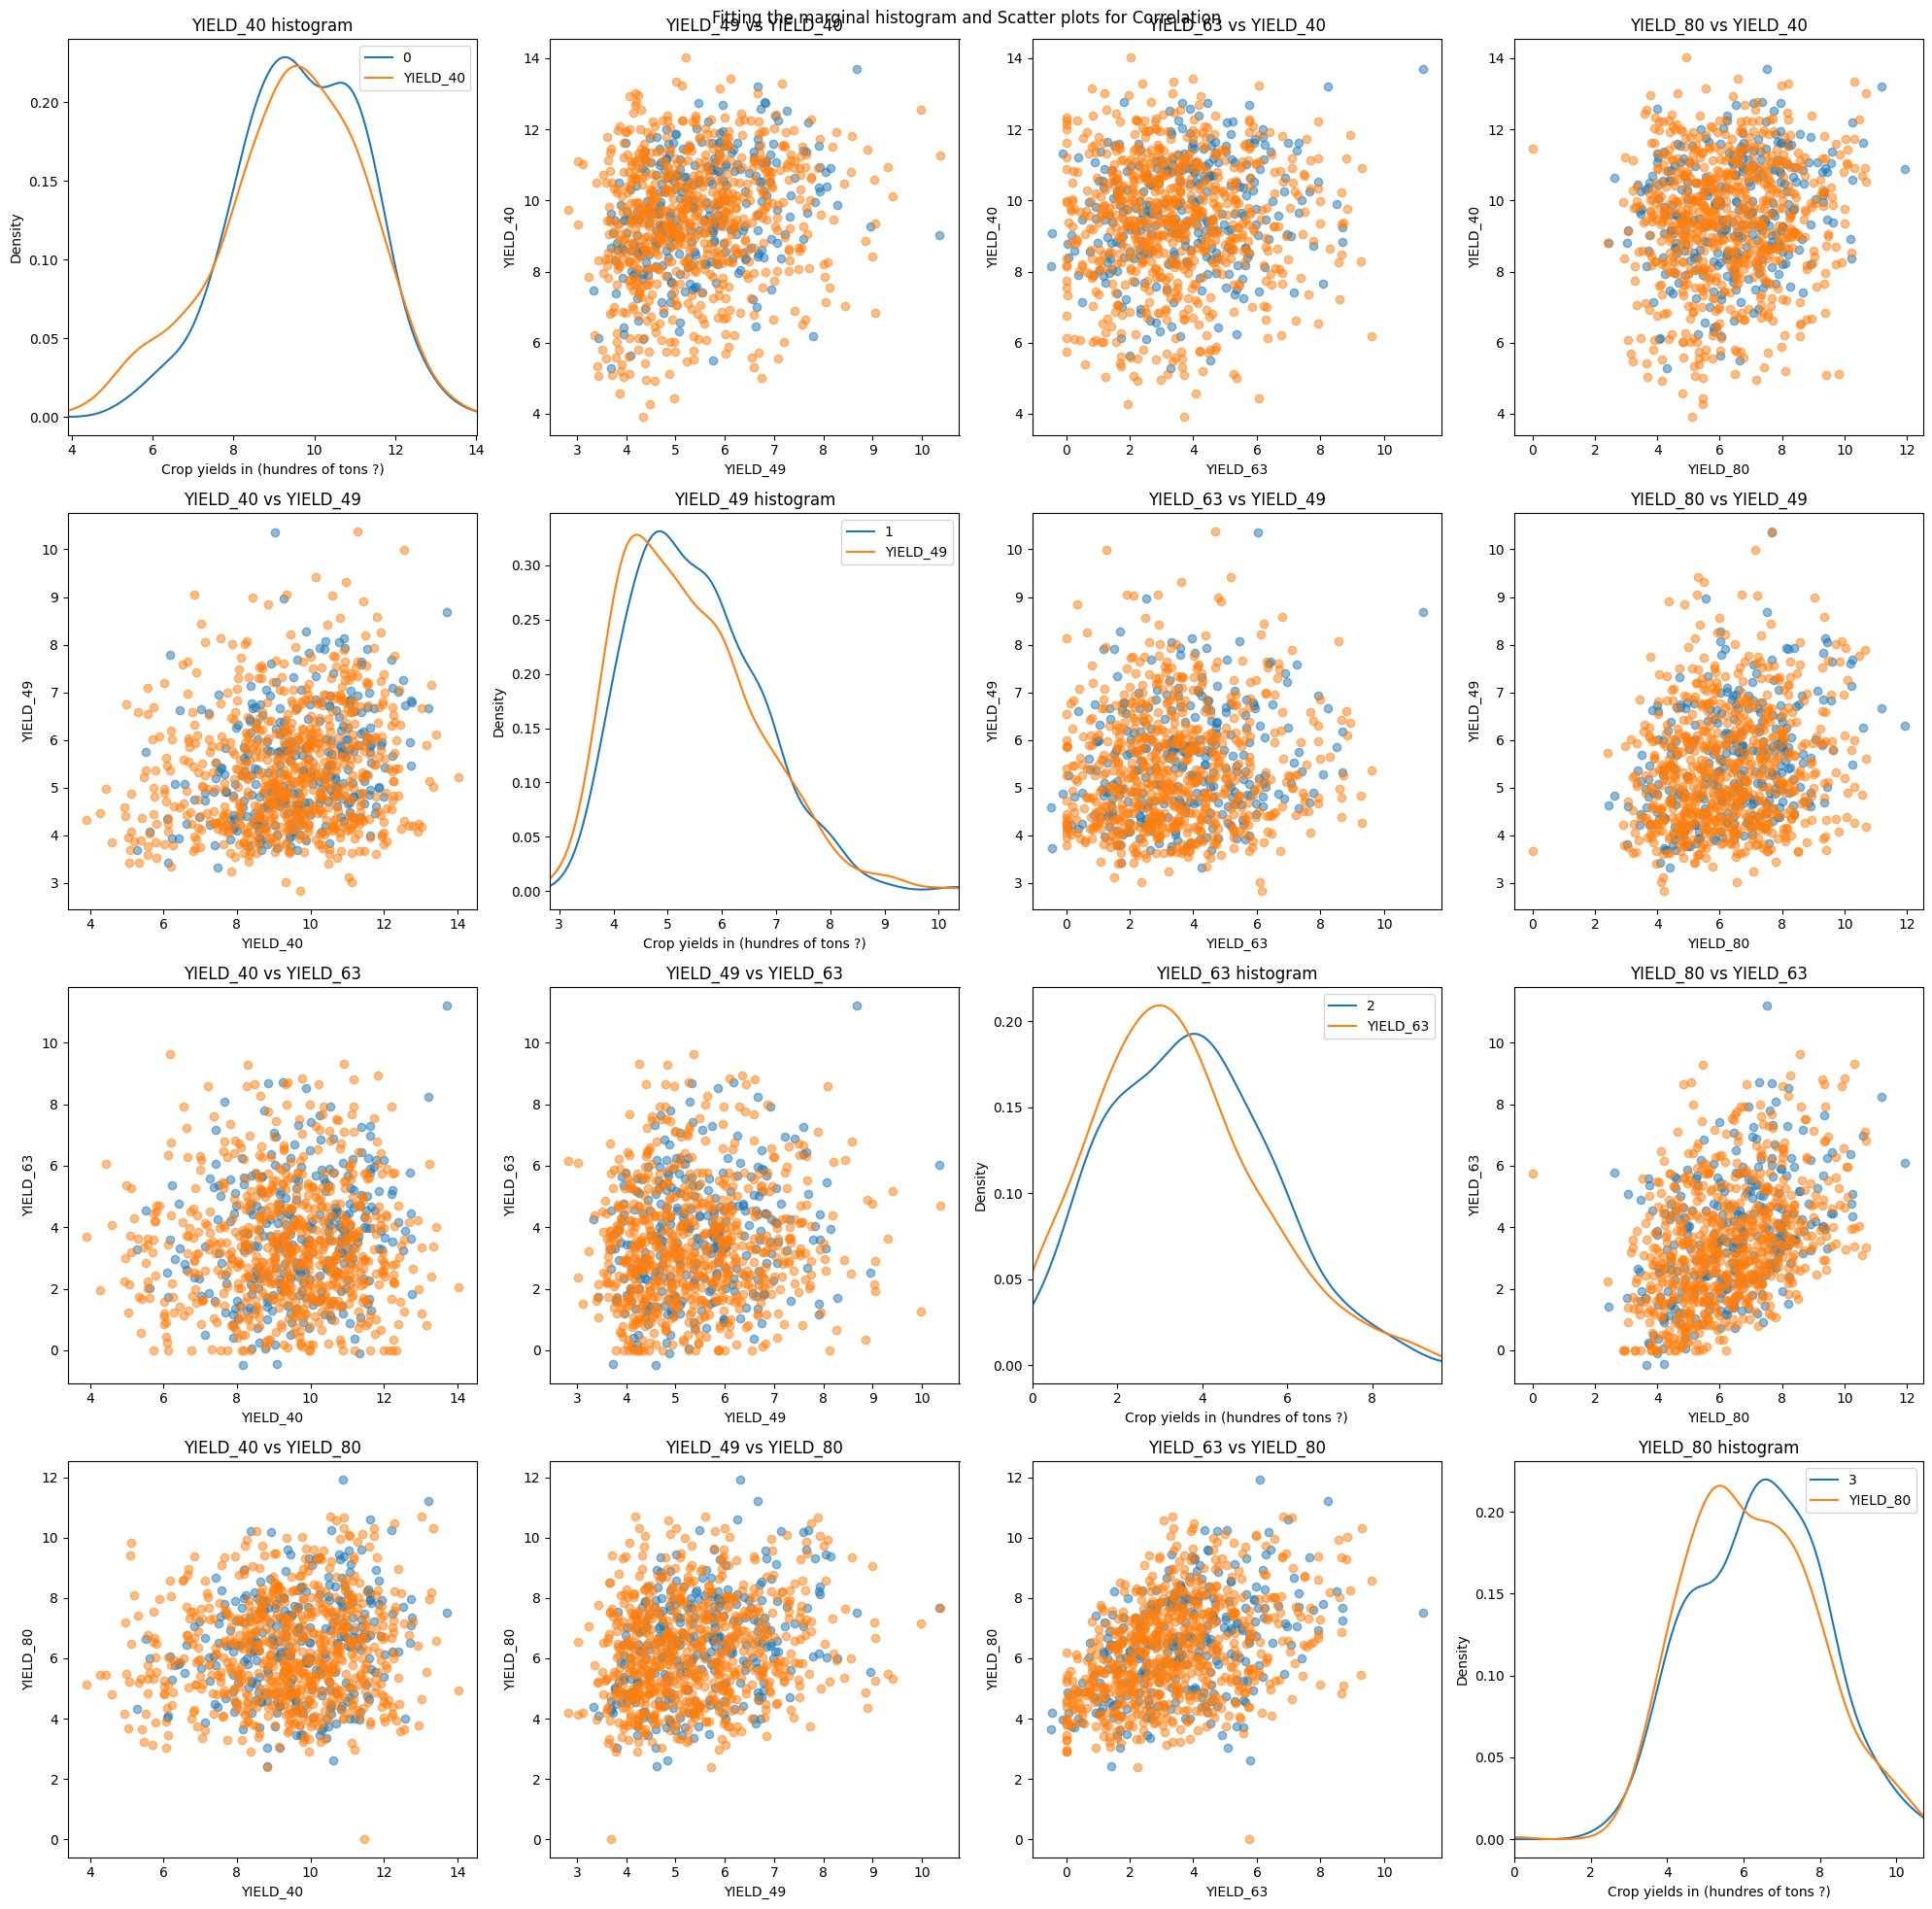

In [73]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

In [74]:
nb_samples = 1000
samples = make_fake_data("normal", n=nb_samples, latent_dim=latent_dim, G=G)
print("train SWD = {}".format(sliced_wasserstein_distance(X_train.values, samples, n_projections=1000)))
print("test SWD = {}".format(sliced_wasserstein_distance(X_test.values, samples, n_projections=1000)))

train SWD = 0.17908580801157287
test SWD = 0.2797430987413919
